In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from torchvision import transforms
import torchvision
import numpy as np
# from resnet import ResNet, Bottleneck

class Trainer:
    def __init__(self, name, model, criterion, optimizer, device):
        """
        Initializes the Trainer.

        Args:
            model (nn.Module): The PyTorch model to train.
            criterion (nn.Module): The loss function.
            optimizer (torch.optim.Optimizer): The optimizer.
            device (torch.device): The device to train on (e.g., 'cuda' or 'cpu').
        """
        self.name = name
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train_epoch(self, dataloader):
        """
        Trains the model for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the training set.

        Returns:
            float: The average training loss for the epoch.
        """
        self.model.train()
        total_loss = 0.0
        num_batches = len(dataloader)

        for inputs, labels in dataloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss

    def validate_epoch(self, dataloader):
        """
        Evaluates the model on the validation set for one epoch.

        Args:
            dataloader (DataLoader): The DataLoader for the validation set.

        Returns:
            float: The average validation loss for the epoch.
            float: The average validation accuracy for the epoch.
        """
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        num_batches = len(dataloader)

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        avg_loss = total_loss / num_batches
        accuracy = correct_predictions / total_samples
        self.val_losses.append(avg_loss)
        self.val_accuracies.append(accuracy)
        return avg_loss, accuracy

    def train(self, train_dataloader, val_dataloader, num_epochs):
        """
        Trains the model for a specified number of epochs and validates it, recording latency and throughput.

        Args:
            train_dataloader (DataLoader): The DataLoader for the training set.
            val_dataloader (DataLoader): The DataLoader for the validation set.
            num_epochs (int): The number of training epochs.
        """
        print(f"Training on {self.device}")
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(train_dataloader)
            val_loss, val_acc = self.validate_epoch(val_dataloader)
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

    def plot_losses_accuracies(self):
        """
        Plots the training loss, validation loss, and validation accuracy against the number of epochs.
        """
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure()
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.plot(epochs, self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(self.name + ' Training and Validation Loss')
        plt.legend()
        plt.show()

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=trans)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)

@torch.no_grad()
def measure_inference_time_with_warmup(model, data_loader, warmup_steps=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    # Warm-up
    for i, (inputs, _) in enumerate(data_loader):
        inputs = inputs.to(device)
        _ = model(inputs)
        if i >= warmup_steps - 1:
            break

    total_inference_time = 0
    num_samples = 0
    start_time = time.time() # Start timer after warm-up

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        _ = model(inputs)
        num_samples += inputs.size(0)

    end_time = time.time()
    total_inference_time = end_time - start_time
    throughput = num_samples / total_inference_time
    avg_latency_per_sample = total_inference_time / num_samples
    print(f"Average Latency per Sample (with warm-up): {avg_latency_per_sample * 1000:.2f} ms")
    print(f"Throughput (with warm-up): {throughput:.2f} samples/second")
    return avg_latency_per_sample, throughput

def fit_one(name,model,epochs,train_dataloader,val_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = Trainer(name = name,model = model,criterion = nn.CrossEntropyLoss(),optimizer= optim.SGD(model.parameters(),weight_decay=0.0001,momentum=0.9),device=device)
    trainer.train(train_dataloader, val_dataloader, epochs)
    trainer.plot_losses_accuracies()
    max_acc = np.max(trainer.val_accuracies)
    avg_latency, throughput = measure_inference_time_with_warmup(model, val_dataloader)
    return avg_latency,max_acc

Training on cuda
Epoch [1/20], Train Loss: 3.2545, Val Loss: 2.4529, Val Acc: 0.2370
Epoch [2/20], Train Loss: 2.5544, Val Loss: 2.0946, Val Acc: 0.3041
Epoch [3/20], Train Loss: 2.3175, Val Loss: 1.9481, Val Acc: 0.3485
Epoch [4/20], Train Loss: 2.1389, Val Loss: 2.0387, Val Acc: 0.3808
Epoch [5/20], Train Loss: 2.0496, Val Loss: 1.9775, Val Acc: 0.4052
Epoch [6/20], Train Loss: 1.9602, Val Loss: 1.7149, Val Acc: 0.4167
Epoch [7/20], Train Loss: 1.8936, Val Loss: 1.6502, Val Acc: 0.4289
Epoch [8/20], Train Loss: 1.8377, Val Loss: 1.7427, Val Acc: 0.4397
Epoch [9/20], Train Loss: 1.7948, Val Loss: 1.6769, Val Acc: 0.4487
Epoch [10/20], Train Loss: 1.7646, Val Loss: 1.6643, Val Acc: 0.4563
Epoch [11/20], Train Loss: 1.7241, Val Loss: 1.5975, Val Acc: 0.4686
Epoch [12/20], Train Loss: 1.6849, Val Loss: 1.9880, Val Acc: 0.4635
Epoch [13/20], Train Loss: 1.6647, Val Loss: 1.6268, Val Acc: 0.4716
Epoch [14/20], Train Loss: 1.6422, Val Loss: 1.5434, Val Acc: 0.4869
Epoch [15/20], Train Loss:

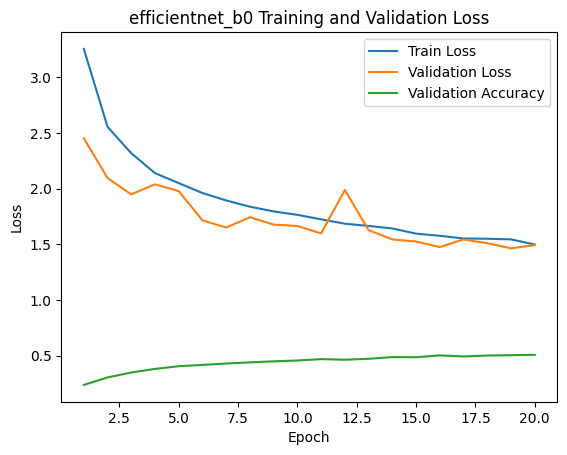

Average Latency per Sample (with warm-up): 0.15 ms
Throughput (with warm-up): 6668.32 samples/second
Training on cuda
Epoch [1/20], Train Loss: 3.2879, Val Loss: 2.5962, Val Acc: 0.1546
Epoch [2/20], Train Loss: 2.6568, Val Loss: 2.2637, Val Acc: 0.2419
Epoch [3/20], Train Loss: 2.4141, Val Loss: 2.1424, Val Acc: 0.2752
Epoch [4/20], Train Loss: 2.2447, Val Loss: 2.0504, Val Acc: 0.2916
Epoch [5/20], Train Loss: 2.1598, Val Loss: 2.0337, Val Acc: 0.3268
Epoch [6/20], Train Loss: 2.0705, Val Loss: 1.8932, Val Acc: 0.3437
Epoch [7/20], Train Loss: 2.0097, Val Loss: 1.7637, Val Acc: 0.3533
Epoch [8/20], Train Loss: 1.9309, Val Loss: 1.8970, Val Acc: 0.3572
Epoch [9/20], Train Loss: 1.9245, Val Loss: 1.8416, Val Acc: 0.3774
Epoch [10/20], Train Loss: 1.8783, Val Loss: 1.7795, Val Acc: 0.3648
Epoch [11/20], Train Loss: 1.8618, Val Loss: 1.7716, Val Acc: 0.3940
Epoch [12/20], Train Loss: 1.8111, Val Loss: 1.7977, Val Acc: 0.3899
Epoch [13/20], Train Loss: 1.7934, Val Loss: 1.6815, Val Acc: 0

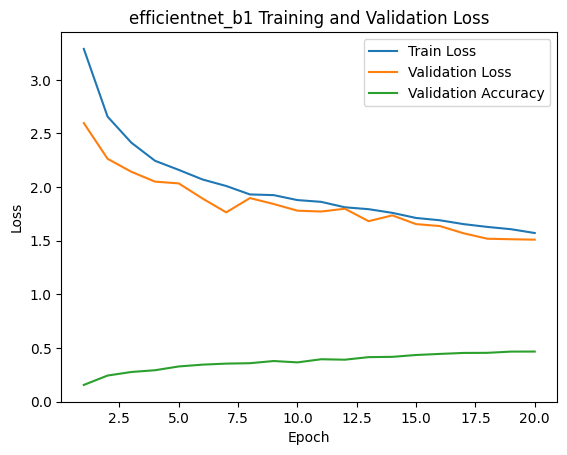

Average Latency per Sample (with warm-up): 0.17 ms
Throughput (with warm-up): 5908.67 samples/second
Training on cuda
Epoch [1/20], Train Loss: 3.3791, Val Loss: 2.7243, Val Acc: 0.1869
Epoch [2/20], Train Loss: 2.7214, Val Loss: 2.2643, Val Acc: 0.2133
Epoch [3/20], Train Loss: 2.4323, Val Loss: 2.1424, Val Acc: 0.2497
Epoch [4/20], Train Loss: 2.3675, Val Loss: 2.1152, Val Acc: 0.2792
Epoch [5/20], Train Loss: 2.2752, Val Loss: 1.9920, Val Acc: 0.3024
Epoch [6/20], Train Loss: 2.1742, Val Loss: 2.0457, Val Acc: 0.3324
Epoch [7/20], Train Loss: 2.0832, Val Loss: 2.1752, Val Acc: 0.3482
Epoch [8/20], Train Loss: 2.0430, Val Loss: 2.2903, Val Acc: 0.3570
Epoch [9/20], Train Loss: 1.9621, Val Loss: 1.8412, Val Acc: 0.3699
Epoch [10/20], Train Loss: 1.9362, Val Loss: 1.8586, Val Acc: 0.3778
Epoch [11/20], Train Loss: 1.9238, Val Loss: 1.8064, Val Acc: 0.3984
Epoch [12/20], Train Loss: 1.8423, Val Loss: 1.9897, Val Acc: 0.4023
Epoch [13/20], Train Loss: 1.9038, Val Loss: 2.0341, Val Acc: 0

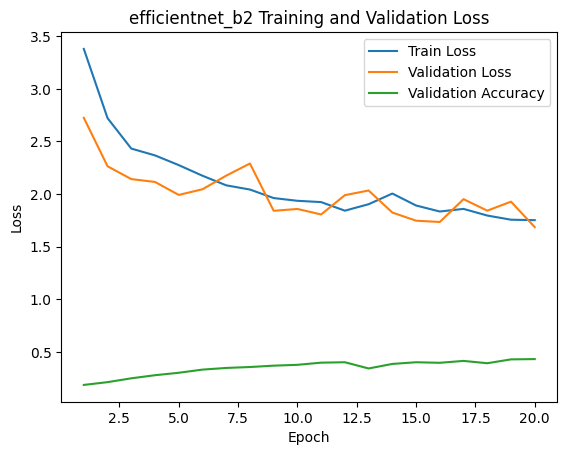

Average Latency per Sample (with warm-up): 0.17 ms
Throughput (with warm-up): 5871.31 samples/second
Training on cuda
Epoch [1/20], Train Loss: 3.5922, Val Loss: 2.8225, Val Acc: 0.1076
Epoch [2/20], Train Loss: 2.9963, Val Loss: 2.7958, Val Acc: 0.1154
Epoch [3/20], Train Loss: 2.7975, Val Loss: 2.4684, Val Acc: 0.1765
Epoch [4/20], Train Loss: 2.5718, Val Loss: 2.2731, Val Acc: 0.2305
Epoch [5/20], Train Loss: 2.4454, Val Loss: 2.1661, Val Acc: 0.2442
Epoch [6/20], Train Loss: 2.3538, Val Loss: 2.3067, Val Acc: 0.2612
Epoch [7/20], Train Loss: 2.3075, Val Loss: 2.0734, Val Acc: 0.2738
Epoch [8/20], Train Loss: 2.2162, Val Loss: 2.0610, Val Acc: 0.2829
Epoch [9/20], Train Loss: 2.1863, Val Loss: 2.0946, Val Acc: 0.3109
Epoch [10/20], Train Loss: 2.1428, Val Loss: 2.0462, Val Acc: 0.3306
Epoch [11/20], Train Loss: 2.0802, Val Loss: 2.2411, Val Acc: 0.3461
Epoch [12/20], Train Loss: 2.0221, Val Loss: 1.9489, Val Acc: 0.3572
Epoch [13/20], Train Loss: 1.9978, Val Loss: 1.9453, Val Acc: 0

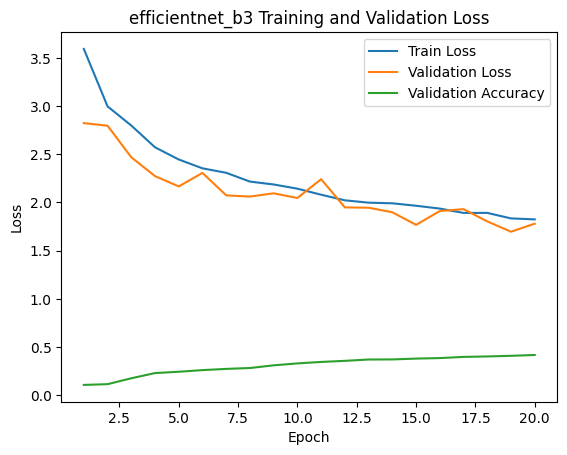

Average Latency per Sample (with warm-up): 0.22 ms
Throughput (with warm-up): 4584.42 samples/second
Training on cuda
Epoch [1/20], Train Loss: 1.7866, Val Loss: 1.5336, Val Acc: 0.4428
Epoch [2/20], Train Loss: 1.3950, Val Loss: 1.3843, Val Acc: 0.4980
Epoch [3/20], Train Loss: 1.2183, Val Loss: 1.3714, Val Acc: 0.5087
Epoch [4/20], Train Loss: 1.0881, Val Loss: 1.2664, Val Acc: 0.5446
Epoch [5/20], Train Loss: 0.9662, Val Loss: 1.2872, Val Acc: 0.5475
Epoch [6/20], Train Loss: 0.8460, Val Loss: 1.2328, Val Acc: 0.5694
Epoch [7/20], Train Loss: 0.7295, Val Loss: 1.3738, Val Acc: 0.5415
Epoch [8/20], Train Loss: 0.6158, Val Loss: 1.4239, Val Acc: 0.5425
Epoch [9/20], Train Loss: 0.5005, Val Loss: 1.3327, Val Acc: 0.5781
Epoch [10/20], Train Loss: 0.3893, Val Loss: 1.3873, Val Acc: 0.5814
Epoch [11/20], Train Loss: 0.2773, Val Loss: 1.4898, Val Acc: 0.5807
Epoch [12/20], Train Loss: 0.1939, Val Loss: 1.5993, Val Acc: 0.5702
Epoch [13/20], Train Loss: 0.1388, Val Loss: 1.6438, Val Acc: 0

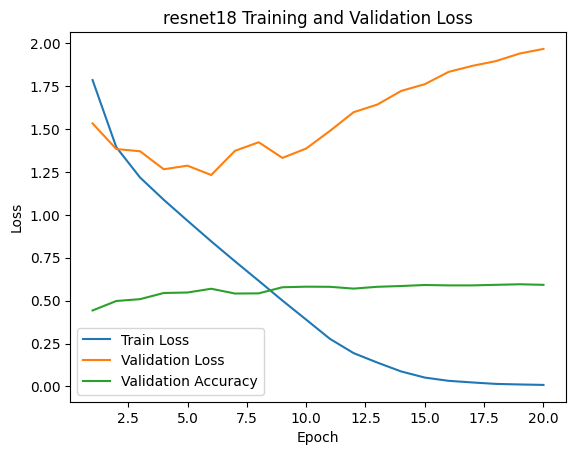

Average Latency per Sample (with warm-up): 0.12 ms
Throughput (with warm-up): 8016.28 samples/second
[('efficientnet_b0', 0.00014996273517608642, np.float64(0.5072)), ('efficientnet_b1', 0.0001692427635192871, np.float64(0.4657)), ('efficientnet_b2', 0.00017031981945037842, np.float64(0.4323)), ('efficientnet_b3', 0.0002181300163269043, np.float64(0.418)), ('resnet18', 0.00012474610805511476, np.float64(0.5955))]


In [ ]:
from torchvision.models import efficientnet_b0,efficientnet_b1,efficientnet_b2,efficientnet_b3,resnet18
model_dict = {}
result_list = []
model_dict['efficientnet_b0'] = efficientnet_b0(num_classes = 10, dropout = 0.2)
model_dict['efficientnet_b1'] = efficientnet_b1(num_classes = 10, dropout = 0.2)
model_dict['efficientnet_b2'] = efficientnet_b2(num_classes = 10, dropout = 0.2)
model_dict['efficientnet_b3'] = efficientnet_b3(num_classes = 10, dropout = 0.2)
model_dict['resnet18'] = resnet18(num_classes = 10)
for name,model in model_dict.items():
    avg_latency,max_acc = fit_one(name,model,20,train_dataloader,val_dataloader)
    result_list.append((name,avg_latency,max_acc))
print(result_list)